In [37]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
# --- Add your entities path ---
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import Experiment  # assumes Experiment is defined there

In [38]:
# --- Constants ---
data_folder = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
FRAME_RATE = 30  # Hz
PRE_TIME = 4     # seconds before event
POST_TIME = 4    # seconds after event
BASELINE_REDUCTION = 0.95
BIN_SIZE = 0.5   # seconds
ALPHA = 0.05

IO

In [39]:
def load_experiments(data_folder):
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            path = os.path.join(data_folder, file)
            with open(path, 'rb') as f:
                exp = pickle.load(f)
                experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments

Grouping 

In [40]:
def get_sapap_genotype(geno_str):
    if "Sapap(" in geno_str:
        start = geno_str.find("Sapap(") + len("Sapap(")
        end = geno_str.find(")", start)
        return geno_str[start:end]
    return None

def group_experiments_by_genotype(experiments):
    WT, KO = [], []
    for exp in experiments:
        geno = get_sapap_genotype(exp.Genotype)
        if geno == 'WT':
            WT.append(exp)
        elif geno == 'KO':
            KO.append(exp)
        else:
            print(f"Warning: unknown genotype for {exp.Mouse_id}")
    print(f"WT mice: {len(WT)}, KO mice: {len(KO)}")
    return WT, KO

def _normalize_sex(sex_str):
    if sex_str is None:
        return None
    s = str(sex_str).strip().lower()
    if s in {"f", "female", "♀", "woman", "girl"}:
        return "Female"
    if s in {"m", "male", "♂", "man", "boy"}:
        return "Male"
    return None

def group_experiments_by_sex(experiments):
    females, males = [], []
    for exp in experiments:
        sx = _normalize_sex(getattr(exp, "Sex", None))
        if sx == "Female":
            females.append(exp)
        elif sx == "Male":
            males.append(exp)
        else:
            print(f"Warning: unknown/blank sex for {getattr(exp, 'Mouse_id', 'UNK')}: {getattr(exp, 'Sex', None)}")
    print(f"Female mice: {len(females)}, Male mice: {len(males)}")
    return females, males


Event extraction

In [41]:
def extract_hd_traces(experiments, pre_sec=4, post_sec=4, frame_rate=FRAME_RATE, align_to="onset"):
    aligned = {}
    for exp in experiments:
        aligned[exp.Mouse_id] = []
        ann = getattr(exp, "Headipping_annotations", None) or []
        if len(ann) == 0:
            continue
        t = np.asarray(exp.GCaMP_data.time)
        z = np.asarray(exp.GCaMP_data.z_score)
        if t.ndim != 1 or len(t) != len(z):
            continue
        for (start_frame, end_frame) in ann:
            event_frame = start_frame if align_to == "onset" else end_frame
            event_s = event_frame / float(frame_rate)
            w_start, w_end = event_s - pre_sec, event_s + post_sec
            if w_start < t[0] or w_end > t[-1]:
                continue
            i0 = int(np.searchsorted(t, w_start, side="left"))
            i1 = int(np.searchsorted(t, w_end,   side="right"))
            trace = z[i0:i1]
            time_rel = t[i0:i1] - event_s
            aligned[exp.Mouse_id].append((trace, time_rel))
    return aligned

Alignment & averaging

In [42]:
def build_common_time(pre_sec=4, post_sec=4, frame_rate=FRAME_RATE):
    n = int(round((pre_sec + post_sec) * frame_rate))
    return np.linspace(-pre_sec, post_sec, n, endpoint=False)

def align_hd_traces_to_common(traces_dict, common_t):
    aligned = {}
    for mouse, traces in traces_dict.items():
        aligned[mouse] = []
        for (y, t_rel) in traces:
            idx = np.argsort(t_rel)
            aligned[mouse].append(np.interp(common_t, t_rel[idx], y[idx]))
    return aligned

def center_traces_by_window(traces_dict, fraction: float = 1.0):
    centered = {}
    for mouse, traces in traces_dict.items():
        out = []
        for arr in traces:
            a = np.asarray(arr, dtype=float)
            m = np.nanmean(a)
            if np.isfinite(m):
                a = a - fraction * m
            out.append(a)
        centered[mouse] = out
    return centered

def compute_hd_avg_traces(aligned_data):
    mouse_avg, all_traces = {}, []
    for mouse, traces in aligned_data.items():
        if len(traces) == 0: 
            continue
        stacked = np.vstack(traces).astype(float)
        avg = np.nanmean(stacked, axis=0)
        dd = 1 if stacked.shape[0] > 1 else 0
        sem = np.nanstd(stacked, axis=0, ddof=dd) / np.sqrt(np.sum(~np.isnan(stacked), axis=0).clip(min=1))
        mouse_avg[mouse] = {"avg": avg, "sem": sem}
        all_traces.append(avg)
    if len(all_traces) == 0:
        return mouse_avg, None, None
    all_traces = np.vstack(all_traces).astype(float)
    group_avg = np.nanmean(all_traces, axis=0)
    dd = 1 if all_traces.shape[0] > 1 else 0
    group_sem = np.nanstd(all_traces, axis=0, ddof=dd) / np.sqrt(np.sum(~np.isnan(all_traces), axis=0).clip(min=1))
    return mouse_avg, np.nan_to_num(group_avg), np.nan_to_num(group_sem)

def count_group_events(traces_dict):
    return int(sum(len(v) for v in traces_dict.values()))


Statistics 

In [43]:
def compare_groups_over_time(groupA, groupB, common_t, bin_size=BIN_SIZE, frame_rate=FRAME_RATE, alpha=ALPHA):
    def stack_mouse(group):
        mats = []
        for mouse, traces in group.items():
            if len(traces) > 0:
                mats.append(np.nanmean(np.vstack(traces), axis=0))
        return np.vstack(mats) if len(mats) > 0 else None

    A, B = stack_mouse(groupA), stack_mouse(groupB)
    if A is None or B is None: 
        return None, None, None

    n_frames = A.shape[1]
    frames_per_bin = int(round(bin_size * frame_rate))
    n_bins = n_frames // frames_per_bin

    bin_centers, pvals = [], []
    for b in range(n_bins):
        i0, i1 = b * frames_per_bin, (b+1) * frames_per_bin
        if i1 > n_frames: break
        A_bin = np.nanmean(A[:, i0:i1], axis=1)
        B_bin = np.nanmean(B[:, i0:i1], axis=1)
        _, p = ttest_ind(A_bin, B_bin, nan_policy="omit", equal_var=False)
        bin_centers.append(np.mean(common_t[i0:i1]))
        pvals.append(p)

    reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    return np.array(bin_centers), np.array(pvals_corr), reject.astype(bool)


Plotting 

In [44]:
def plot_traces(common_t, mouse_data, group_avg, group_sem, title, color):
    if group_avg is None or len(group_avg) == 0:
        print(f"⚠️ Skipping plot for {title} — no valid events found.")
        return

    ok = np.isfinite(common_t) & np.isfinite(group_avg) & np.isfinite(group_sem)
    t = common_t[ok]
    mu = group_avg[ok]
    se = np.abs(group_sem[ok])

    plt.figure(figsize=(8, 5))
    for m, d in mouse_data.items():
        if "avg" in d and np.isfinite(d["avg"]).any():
            plt.plot(t, np.interp(t, common_t[:len(d["avg"])], d["avg"]), color='gray', alpha=0.5)

    plt.plot(t, mu, color=color, linewidth=2, label=title)
    plt.fill_between(t, mu - se, mu + se, color=color, alpha=0.3)

    plt.axvline(0, linestyle='--', color='k')
    plt.xlabel("Time (s, aligned to event)")
    plt.ylabel("Z-scored dF/F")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_combined_groups_with_stats(common_t,
                                    groupA, gavg_A, gsem_A, name_A, color_A,
                                    groupB, gavg_B, gsem_B, name_B, color_B,
                                    n_mice_A, n_events_A,
                                    n_mice_B, n_events_B,
                                    bin_size=BIN_SIZE, alpha=ALPHA):
    plt.figure(figsize=(12, 6))

    # Plot group A
    if gavg_A is not None and gsem_A is not None:
        label_A = f"{name_A} (mice={n_mice_A}, events={n_events_A})"
        plt.plot(common_t, gavg_A, color=color_A, linewidth=2, label=label_A)
        plt.fill_between(common_t, gavg_A-gsem_A, gavg_A+gsem_A, color=color_A, alpha=0.3)

    # Plot group B
    if gavg_B is not None and gsem_B is not None:
        label_B = f"{name_B} (mice={n_mice_B}, events={n_events_B})"
        plt.plot(common_t, gavg_B, color=color_B, linewidth=2, label=label_B)
        plt.fill_between(common_t, gavg_B-gsem_B, gavg_B+gsem_B, color=color_B, alpha=0.3)

    plt.axvline(0, linestyle="--", color="k")
    plt.xlabel("Time (s, aligned to event)")
    plt.ylabel("Z-scored dF/F")
    plt.title(f"{name_A} vs {name_B}")
    plt.legend()

    # Run statistical comparison
    bin_centers, pvals_corr, sig_mask = compare_groups_over_time(groupA, groupB, common_t,
                                                                 bin_size=bin_size, alpha=alpha)
    if bin_centers is not None:
        sig_y = min(np.nanmin(gavg_A-gsem_A), np.nanmin(gavg_B-gsem_B)) + 0.8
        for x, sig in zip(bin_centers, sig_mask):
            if sig:
                plt.plot(x, sig_y, marker="*", color="black", markersize=10)

        # Console output
        print(f"\nStatistical test results: {name_A} vs {name_B}")
        for t, p, s in zip(bin_centers, pvals_corr, sig_mask):
            mark = "*" if s else "-"
            print(f"  Bin @ {t:+.2f}s : p={p:.4f} {mark}")

    plt.tight_layout()
    plt.show()

Main 

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Total .pkl files loaded: 13
WT mice: 5, KO mice: 8
Female mice: 9, Male mice: 4


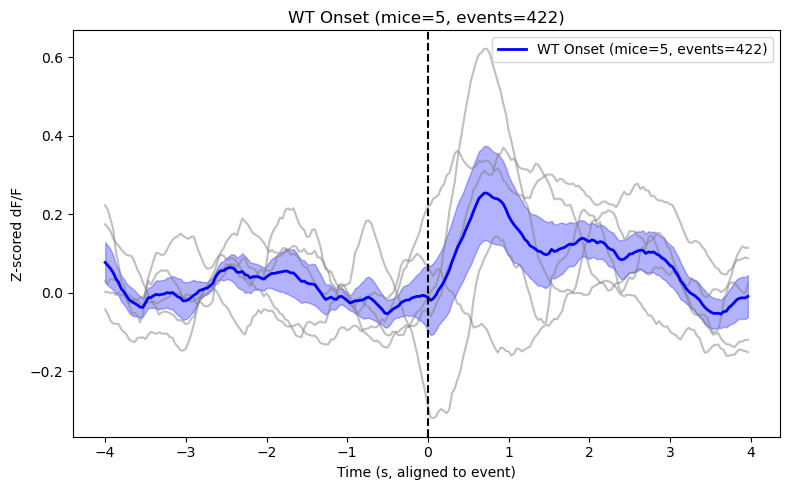

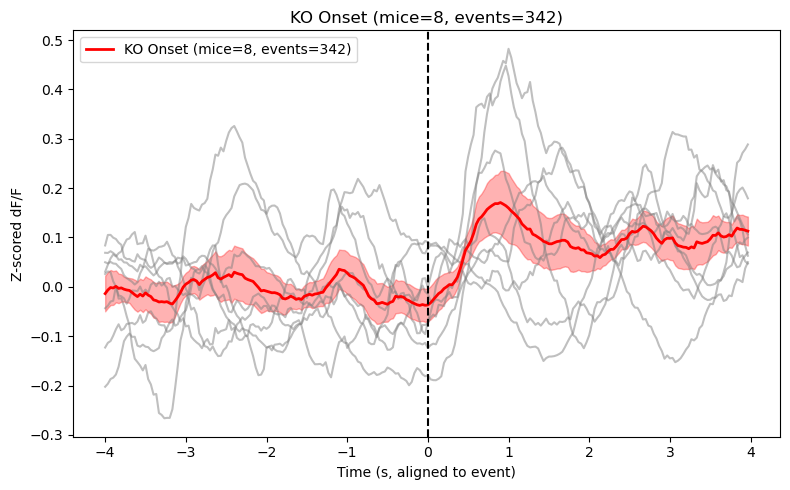

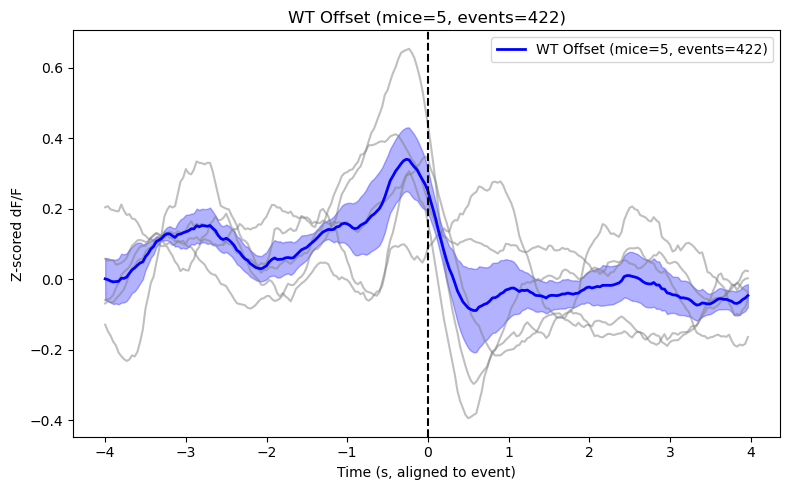

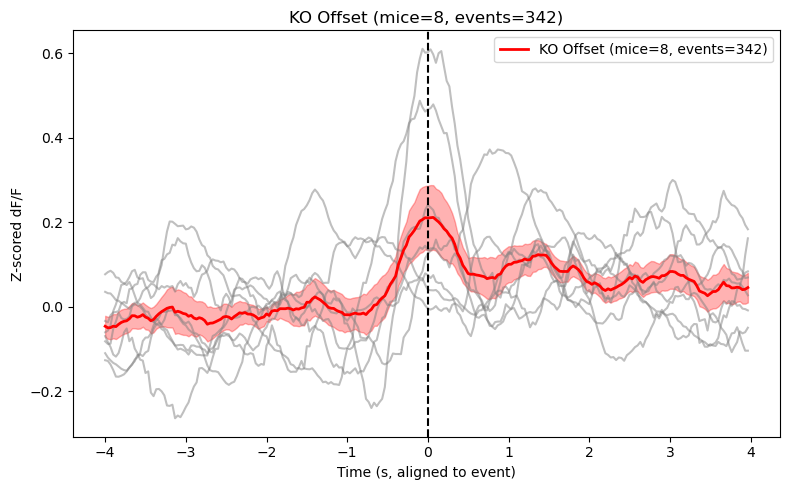

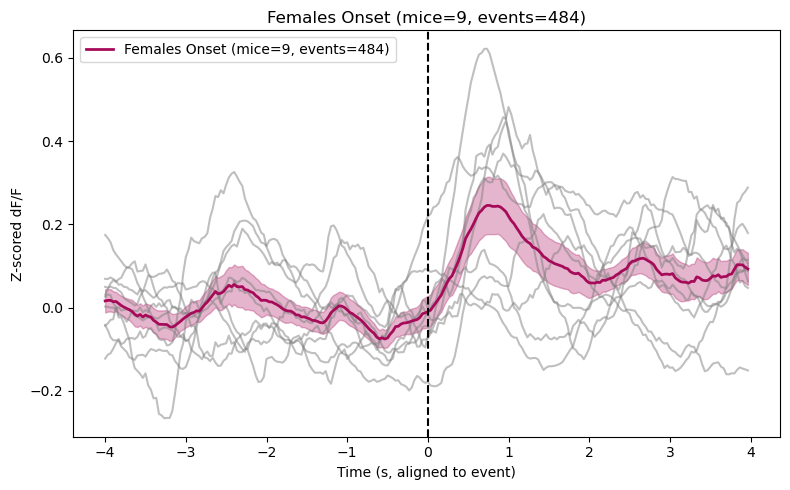

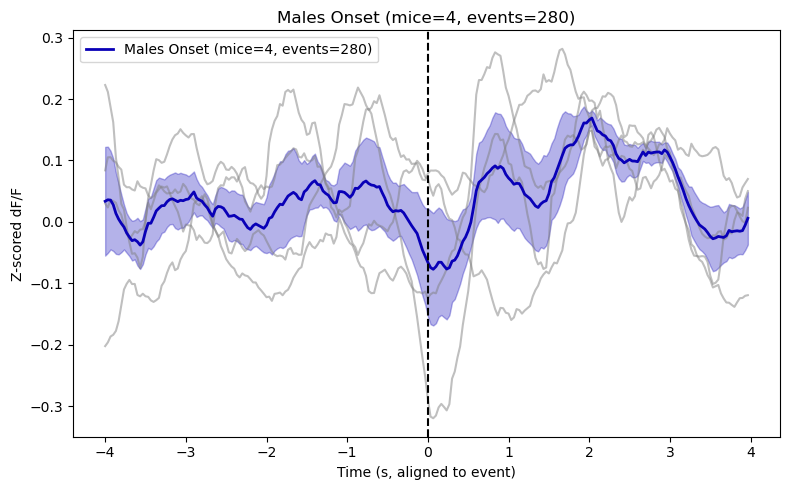

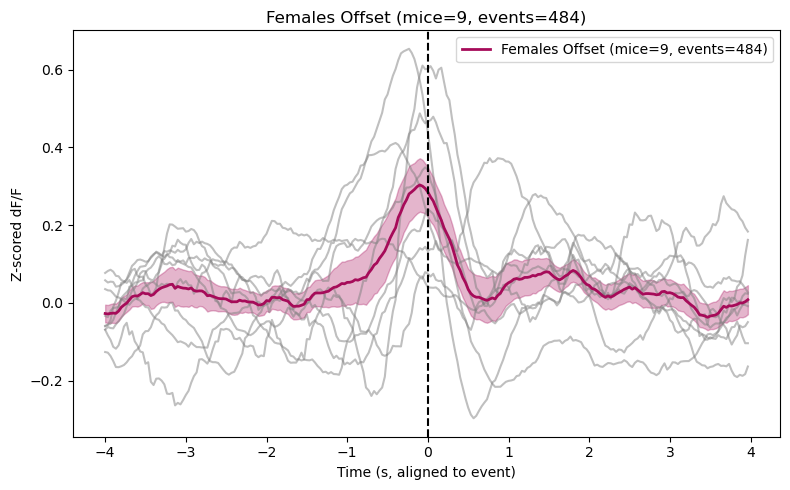

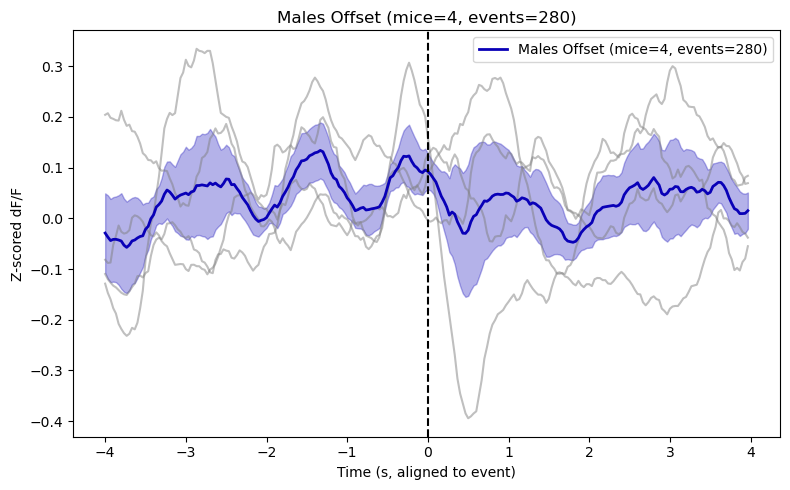


Statistical test results: WT vs KO (Onset)
  Bin @ -3.77s : p=0.9812 -
  Bin @ -3.27s : p=0.9812 -
  Bin @ -2.77s : p=0.9893 -
  Bin @ -2.27s : p=0.9812 -
  Bin @ -1.77s : p=0.9812 -
  Bin @ -1.27s : p=0.9812 -
  Bin @ -0.77s : p=0.9812 -
  Bin @ -0.27s : p=0.9812 -
  Bin @ +0.23s : p=0.9812 -
  Bin @ +0.73s : p=0.9812 -
  Bin @ +1.23s : p=0.9812 -
  Bin @ +1.73s : p=0.9812 -
  Bin @ +2.23s : p=0.9812 -
  Bin @ +2.73s : p=0.9812 -
  Bin @ +3.23s : p=0.9812 -
  Bin @ +3.73s : p=0.4306 -


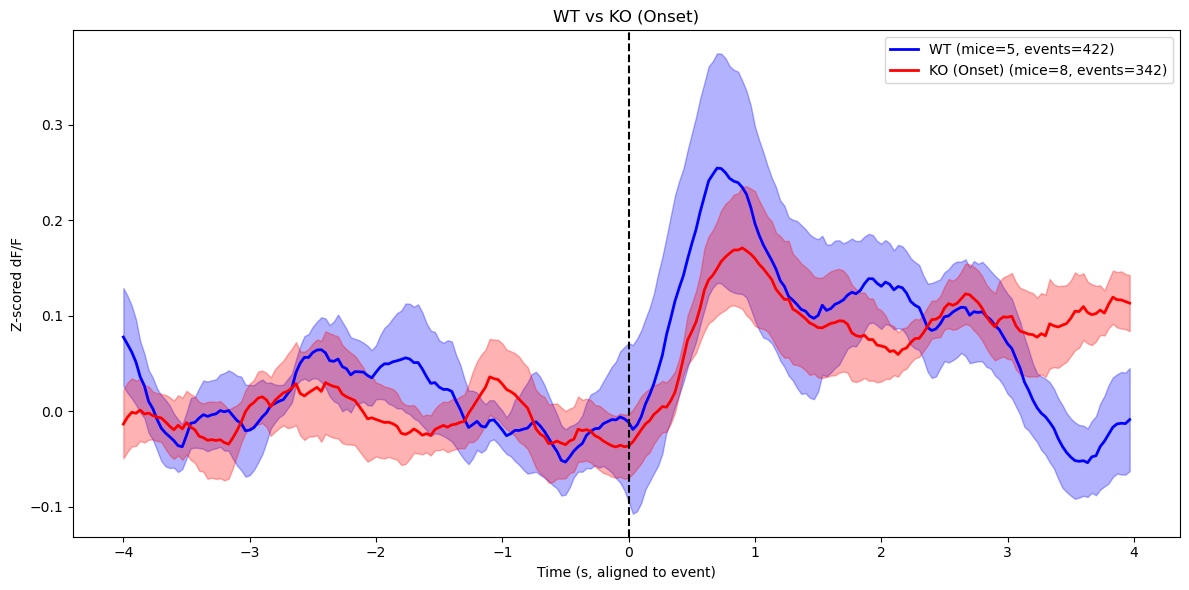


Statistical test results: WT vs KO (offset)
  Bin @ -3.77s : p=0.5026 -
  Bin @ -3.27s : p=0.1108 -
  Bin @ -2.77s : p=0.1108 -
  Bin @ -2.27s : p=0.1536 -
  Bin @ -1.77s : p=0.3107 -
  Bin @ -1.27s : p=0.1110 -
  Bin @ -0.77s : p=0.2042 -
  Bin @ -0.27s : p=0.2172 -
  Bin @ +0.23s : p=0.3209 -
  Bin @ +0.73s : p=0.3209 -
  Bin @ +1.23s : p=0.1204 -
  Bin @ +1.73s : p=0.1108 -
  Bin @ +2.23s : p=0.3505 -
  Bin @ +2.73s : p=0.3505 -
  Bin @ +3.23s : p=0.1412 -
  Bin @ +3.73s : p=0.1204 -


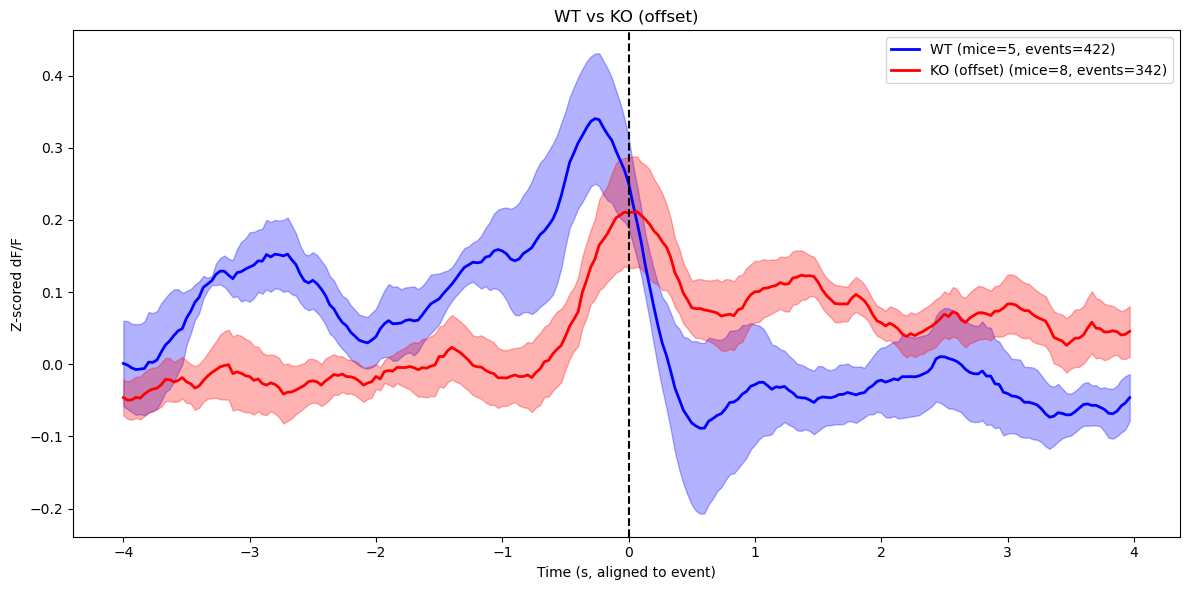


Statistical test results: Females vs Males (Onset)
  Bin @ -3.77s : p=0.9376 -
  Bin @ -3.27s : p=0.6112 -
  Bin @ -2.77s : p=0.7948 -
  Bin @ -2.27s : p=0.7948 -
  Bin @ -1.77s : p=0.8082 -
  Bin @ -1.27s : p=0.4342 -
  Bin @ -0.77s : p=0.5182 -
  Bin @ -0.27s : p=0.7948 -
  Bin @ +0.23s : p=0.5182 -
  Bin @ +0.73s : p=0.4342 -
  Bin @ +1.23s : p=0.5182 -
  Bin @ +1.73s : p=0.8512 -
  Bin @ +2.23s : p=0.4342 -
  Bin @ +2.73s : p=0.9291 -
  Bin @ +3.23s : p=0.7948 -
  Bin @ +3.73s : p=0.4342 -


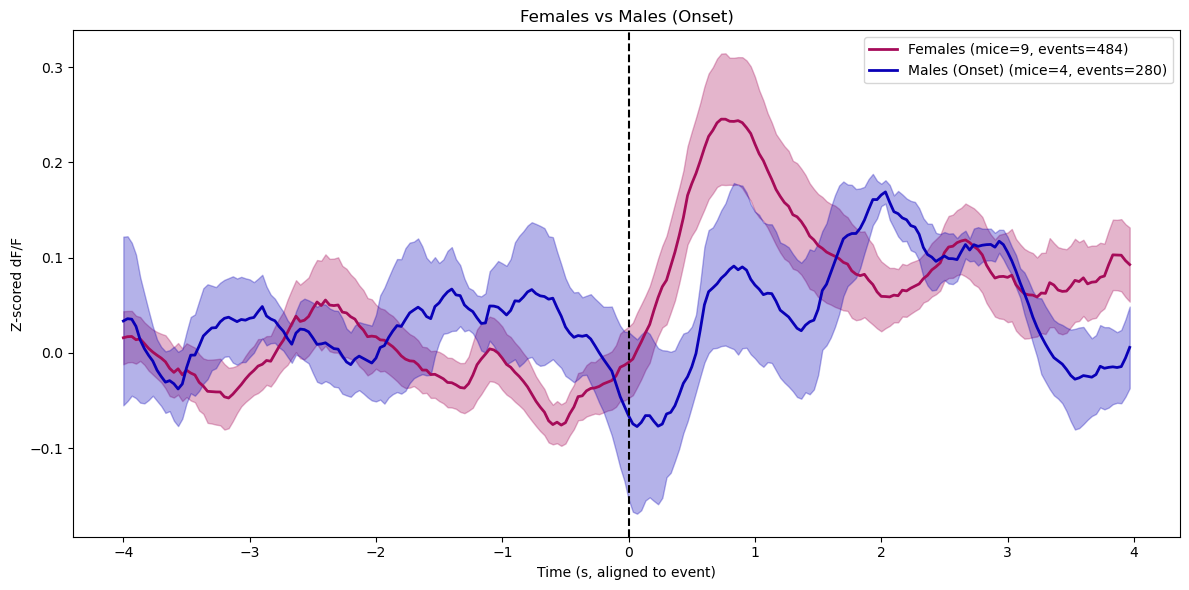


Statistical test results: Females vs Males (offset)
  Bin @ -3.77s : p=0.8858 -
  Bin @ -3.27s : p=0.9525 -
  Bin @ -2.77s : p=0.8858 -
  Bin @ -2.27s : p=0.8858 -
  Bin @ -1.77s : p=0.8858 -
  Bin @ -1.27s : p=0.8858 -
  Bin @ -0.77s : p=0.8858 -
  Bin @ -0.27s : p=0.6465 -
  Bin @ +0.23s : p=0.6465 -
  Bin @ +0.73s : p=0.9525 -
  Bin @ +1.23s : p=0.8858 -
  Bin @ +1.73s : p=0.6465 -
  Bin @ +2.23s : p=0.9525 -
  Bin @ +2.73s : p=0.8858 -
  Bin @ +3.23s : p=0.8858 -
  Bin @ +3.73s : p=0.8858 -


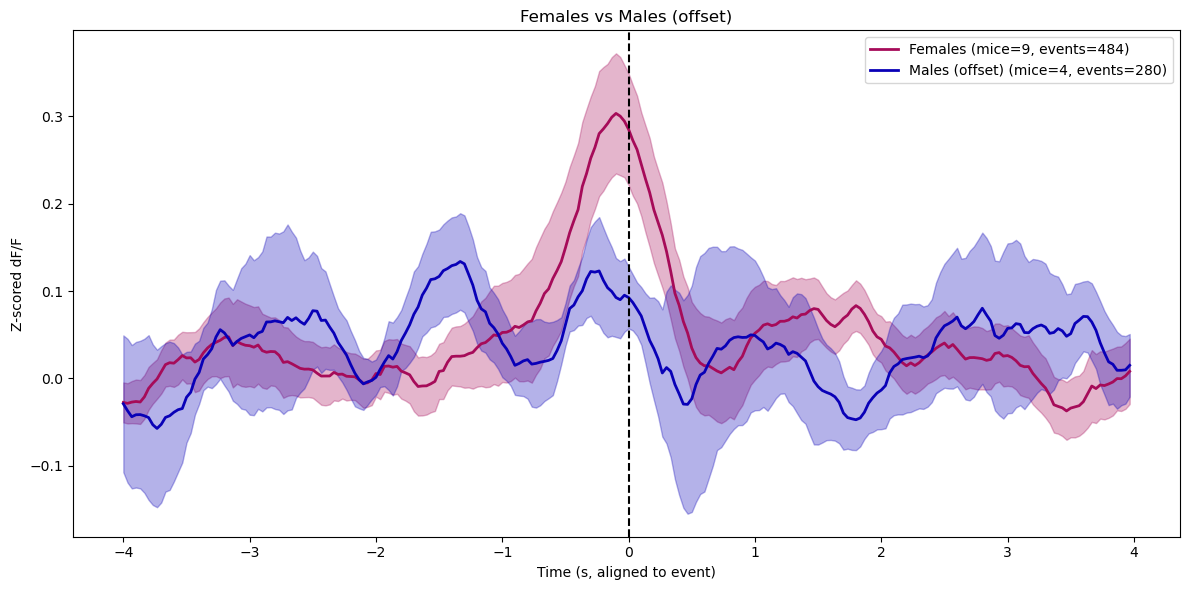

In [45]:
if __name__ == '__main__':
    # Load & group
    exps = load_experiments(data_folder)
    WT, KO = group_experiments_by_genotype(exps)
    Females, Males = group_experiments_by_sex(exps)

    # Common time grid
    common_t = build_common_time(PRE_TIME, POST_TIME, FRAME_RATE)

    # ----- Extract traces (onset & offset) -----
    raw_WT_on  = extract_hd_traces(WT,      PRE_TIME, POST_TIME, FRAME_RATE, "onset")
    raw_KO_on  = extract_hd_traces(KO,      PRE_TIME, POST_TIME, FRAME_RATE, "onset")
    raw_WT_off = extract_hd_traces(WT,      PRE_TIME, POST_TIME, FRAME_RATE, "offset")
    raw_KO_off = extract_hd_traces(KO,      PRE_TIME, POST_TIME, FRAME_RATE, "offset")

    raw_F_on   = extract_hd_traces(Females, PRE_TIME, POST_TIME, FRAME_RATE, "onset")
    raw_M_on   = extract_hd_traces(Males,   PRE_TIME, POST_TIME, FRAME_RATE, "onset")
    raw_F_off  = extract_hd_traces(Females, PRE_TIME, POST_TIME, FRAME_RATE, "offset")
    raw_M_off  = extract_hd_traces(Males,   PRE_TIME, POST_TIME, FRAME_RATE, "offset")

    # ----- Align to common grid -----
    aligned_WT_on  = align_hd_traces_to_common(raw_WT_on,  common_t)
    aligned_KO_on  = align_hd_traces_to_common(raw_KO_on,  common_t)
    aligned_WT_off = align_hd_traces_to_common(raw_WT_off, common_t)
    aligned_KO_off = align_hd_traces_to_common(raw_KO_off, common_t)

    aligned_F_on   = align_hd_traces_to_common(raw_F_on,   common_t)
    aligned_M_on   = align_hd_traces_to_common(raw_M_on,   common_t)
    aligned_F_off  = align_hd_traces_to_common(raw_F_off,  common_t)
    aligned_M_off  = align_hd_traces_to_common(raw_M_off,  common_t)

    # ----- Center each event by window mean (fraction) -----
    centered_WT_on  = center_traces_by_window(aligned_WT_on,  BASELINE_REDUCTION)
    centered_KO_on  = center_traces_by_window(aligned_KO_on,  BASELINE_REDUCTION)
    centered_WT_off = center_traces_by_window(aligned_WT_off, BASELINE_REDUCTION)
    centered_KO_off = center_traces_by_window(aligned_KO_off, BASELINE_REDUCTION)

    centered_F_on   = center_traces_by_window(aligned_F_on,   BASELINE_REDUCTION)
    centered_M_on   = center_traces_by_window(aligned_M_on,   BASELINE_REDUCTION)
    centered_F_off  = center_traces_by_window(aligned_F_off,  BASELINE_REDUCTION)
    centered_M_off  = center_traces_by_window(aligned_M_off,  BASELINE_REDUCTION)

    # ----- Per-mouse & group averages -----
    mouse_WT_on,  gavg_WT_on,  gsem_WT_on  = compute_hd_avg_traces(centered_WT_on)
    mouse_KO_on,  gavg_KO_on,  gsem_KO_on  = compute_hd_avg_traces(centered_KO_on)
    mouse_WT_off, gavg_WT_off, gsem_WT_off = compute_hd_avg_traces(centered_WT_off)
    mouse_KO_off, gavg_KO_off, gsem_KO_off = compute_hd_avg_traces(centered_KO_off)

    mouse_F_on,   gavg_F_on,   gsem_F_on   = compute_hd_avg_traces(centered_F_on)
    mouse_M_on,   gavg_M_on,   gsem_M_on   = compute_hd_avg_traces(centered_M_on)
    mouse_F_off,  gavg_F_off,  gsem_F_off  = compute_hd_avg_traces(centered_F_off)
    mouse_M_off,  gavg_M_off,  gsem_M_off  = compute_hd_avg_traces(centered_M_off)

    # ----- Separate per-group plots (Genotype) -----
    plot_traces(common_t, mouse_WT_on,  gavg_WT_on,  gsem_WT_on,
                title=f"WT Onset (mice={len(mouse_WT_on)}, events={count_group_events(centered_WT_on)})",
                color="blue")
    plot_traces(common_t, mouse_KO_on,  gavg_KO_on,  gsem_KO_on,
                title=f"KO Onset (mice={len(mouse_KO_on)}, events={count_group_events(centered_KO_on)})",
                color="red")
    plot_traces(common_t, mouse_WT_off, gavg_WT_off, gsem_WT_off,
                title=f"WT Offset (mice={len(mouse_WT_off)}, events={count_group_events(centered_WT_off)})",
                color="blue")
    plot_traces(common_t, mouse_KO_off, gavg_KO_off, gsem_KO_off,
                title=f"KO Offset (mice={len(mouse_KO_off)}, events={count_group_events(centered_KO_off)})",
                color="red")

    # ----- Separate per-group plots (Sex) -----
    plot_traces(common_t, mouse_F_on,   gavg_F_on,   gsem_F_on,
                title=f"Females Onset (mice={len(mouse_F_on)}, events={count_group_events(centered_F_on)})",
                color="#A60B59")
    plot_traces(common_t, mouse_M_on,   gavg_M_on,   gsem_M_on,
                title=f"Males Onset (mice={len(mouse_M_on)}, events={count_group_events(centered_M_on)})",
                color="#0900B7")
    plot_traces(common_t, mouse_F_off,  gavg_F_off,  gsem_F_off,
                title=f"Females Offset (mice={len(mouse_F_off)}, events={count_group_events(centered_F_off)})",
                color="#A60B59")
    plot_traces(common_t, mouse_M_off,  gavg_M_off,  gsem_M_off,
                title=f"Males Offset (mice={len(mouse_M_off)}, events={count_group_events(centered_M_off)})",
                color="#0900B7")

    # ----- Combined plots with stats (Genotype) -----
    plot_combined_groups_with_stats(
        common_t,
        centered_WT_on,  gavg_WT_on,  gsem_WT_on,  "WT", "blue",
        centered_KO_on,  gavg_KO_on,  gsem_KO_on,  "KO (Onset)", "red",
        n_mice_A=len(mouse_WT_on),  n_events_A=count_group_events(centered_WT_on),
        n_mice_B=len(mouse_KO_on),  n_events_B=count_group_events(centered_KO_on),
        bin_size=BIN_SIZE, alpha=ALPHA
    )
    plot_combined_groups_with_stats(
        common_t,
        centered_WT_off, gavg_WT_off, gsem_WT_off, "WT", "blue",
        centered_KO_off, gavg_KO_off, gsem_KO_off, "KO (offset)", "red",
        n_mice_A=len(mouse_WT_off), n_events_A=count_group_events(centered_WT_off),
        n_mice_B=len(mouse_KO_off), n_events_B=count_group_events(centered_KO_off),
        bin_size=BIN_SIZE, alpha=ALPHA
    )

    # ----- Combined plots with stats (Sex) -----
    plot_combined_groups_with_stats(
        common_t,
        centered_F_on,  gavg_F_on,  gsem_F_on,  "Females", "#A60B59",
        centered_M_on,  gavg_M_on,  gsem_M_on,  "Males (Onset)",   "#0900B7",
        n_mice_A=len(mouse_F_on),  n_events_A=count_group_events(centered_F_on),
        n_mice_B=len(mouse_M_on),  n_events_B=count_group_events(centered_M_on),
        bin_size=BIN_SIZE, alpha=ALPHA
    )
    plot_combined_groups_with_stats(
        common_t,
        centered_F_off, gavg_F_off, gsem_F_off, "Females", "#A60B59",
        centered_M_off, gavg_M_off, gsem_M_off, "Males (offset)",   "#0900B7",
        n_mice_A=len(mouse_F_off), n_events_A=count_group_events(centered_F_off),
        n_mice_B=len(mouse_M_off), n_events_B=count_group_events(centered_M_off),
        bin_size=BIN_SIZE, alpha=ALPHA
    )